CIFAR10 dataset trained on all classes with resnet56 without augmentation.

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('/home/henrik/master_thesis/code/utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [18]:
data_dir = pathlib.Path('/mnt/sdb/kvasir-dataset-v2/')

config = {
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "MODEL": 'resnet56',
    "DS_INFO": 'complete',
    "resample": True,
    "neg_class": ['ship'],
    "NUM_EPOCHS": 40,
    "BATCH_SIZE": 64,
    "IMG_SIZE": (128, 128, 3),
    "outcast": None,
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["NUM_EPOCHS"], config["BATCH_SIZE"], 
                                     config["IMG_SIZE"][1], config["DS_INFO"], config["MODEL"])

Create training, testing and validation dataset from utils/data_prep.py

In [3]:
train_ds, test_ds, val_ds, params = create_dataset(config)

Directories:  ['esophagitis' 'normal-pylorus' 'ulcerative-colitis' 'normal-cecum'
 'normal-z-line' 'polyps' 'dyed-resection-margins' 'dyed-lifted-polyps']

esophagitis       : 1000
normal-pylorus    : 1000
ulcerative-colitis: 1000
normal-cecum      : 1000
normal-z-line     : 1000
polyps            : 1000
dyed-resection-margins: 1000
dyed-lifted-polyps: 1000

Total number of images: 8000, in 8 classes
Dataset.list_files:  /mnt/sdb/kvasir-dataset-v2/*/*.*g 

[6 2 6 7 5 5 5 4 4 5]
[5 2 6 6 2 7 2 5 4 7]
[3 4 7 4 4 2 6 1 5 2]
[7 6 0 1 4 3 6 3 3 0]
[0 7 2 7 1 5 0 3 3 7]
[7 5 4 7 7 6 0 2 2 0]
[0 1 6 3 5 0 7 0 6 2]
[6 6 2 2 0 3 0 3 3 2]
[6 3 3 7 2 1 7 7 0 7]
[7 4 6 3 6 2 5 4 0 6]

Full dataset sample size:         8000
Train dataset sample size:        5600
Test dataset sample size:         1200
Validation dataset sample size:   1200


## Training

### Resnet56 (not pretrained)
See https://lambdalabs.com/blog/tensorflow-2-0-tutorial-01-image-classification-basics/

https://github.com/lambdal/TensorFlow2-tutorial/tree/master/01-basic-image-classification

In [19]:
import resnet
import datetime
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler

NUM_GPUS = 1
BS_PER_GPU = config["BATCH_SIZE"]
BASE_LEARNING_RATE = 0.1
LR_SCHEDULE = [(0.1, 30), (0.01, 45)]

In [5]:
PATH = os.getenv('PATH')
%env PATH=/home/henrik/anaconda3/envs/TF2/bin:$PATH

env: PATH=/home/henrik/anaconda3/envs/TF2/bin:/home/henrik/anaconda3/envs/TF2/bin:/home/henrik/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/home/henrik/.dotnet/tools


In [6]:
def schedule(epoch):
    initial_learning_rate = BASE_LEARNING_RATE * BS_PER_GPU / 128
    learning_rate = initial_learning_rate
    for mult, start_epoch in LR_SCHEDULE:
        if epoch >= start_epoch:
            learning_rate = initial_learning_rate * mult
        else:
            break
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

Create and compile the model

In [7]:
img_input = tf.keras.layers.Input(shape=config["IMG_SIZE"])
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

if NUM_GPUS == 1:
    resnet56_model = resnet.resnet56(img_input=img_input, classes=params["NUM_CLASSES"])
    resnet56_model.compile(
              optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
else:
    mirrored_strategy = tf.distribute.MirroredStrategy()
    with mirrored_strategy.scope():
        resnet56_model = resnet.resnet56(img_input=img_input, classes=params["NUM_CLASSES"])
        resnet56_model.compile(
                optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])  

In [8]:
if config["verbosity"] > 0:
    resnet56_model.summary()

Model: "resnet56"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 130, 130, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 16) 448         conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 16) 64          conv1[0][0]                      
___________________________________________________________________________________________

In [9]:
log_dir="logs/resnet56/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        update_freq='batch',
        histogram_freq=1)

lr_schedule_callback = LearningRateScheduler(schedule)

Train the model

In [20]:
history = resnet56_model.fit(
        train_ds,
        steps_per_epoch = params["train_size"] // config["BATCH_SIZE"],
        epochs = config["NUM_EPOCHS"],
        validation_data = test_ds,
        validation_steps = params["test_size"] // config["BATCH_SIZE"],
        validation_freq = 1,
        callbacks = [tensorboard_callback, lr_schedule_callback])

Train for 87 steps, validate for 18 steps
Epoch 1/40
87/87 [==============================] - 29s 330ms/step - loss: 1.8213 - sparse_categorical_accuracy: 0.5896 - val_loss: 3.3543 - val_sparse_categorical_accuracy: 0.3108
Epoch 2/40
87/87 [==============================] - 28s 327ms/step - loss: 1.7657 - sparse_categorical_accuracy: 0.6087 - val_loss: 2.2216 - val_sparse_categorical_accuracy: 0.4774
Epoch 3/40
87/87 [==============================] - 28s 327ms/step - loss: 1.6857 - sparse_categorical_accuracy: 0.6202 - val_loss: 2.1937 - val_sparse_categorical_accuracy: 0.4566
Epoch 4/40
87/87 [==============================] - 28s 327ms/step - loss: 1.6600 - sparse_categorical_accuracy: 0.6178 - val_loss: 2.3120 - val_sparse_categorical_accuracy: 0.4175
Epoch 5/40
87/87 [==============================] - 29s 328ms/step - loss: 1.6037 - sparse_categorical_accuracy: 0.6315 - val_loss: 1.8823 - val_sparse_categorical_accuracy: 0.5182
Epoch 6/40
87/87 [==============================] - 2

In [11]:
# resnet56_model.save('models/{}.h5'.format(model_name))
# resnet56_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Evaluate the model

In [21]:
resnet56_evaluate = resnet56_model.evaluate(val_ds, verbose=2, steps=params["val_size"] // config["BATCH_SIZE"])

18/18 - 2s - loss: 1.0589 - sparse_categorical_accuracy: 0.6962


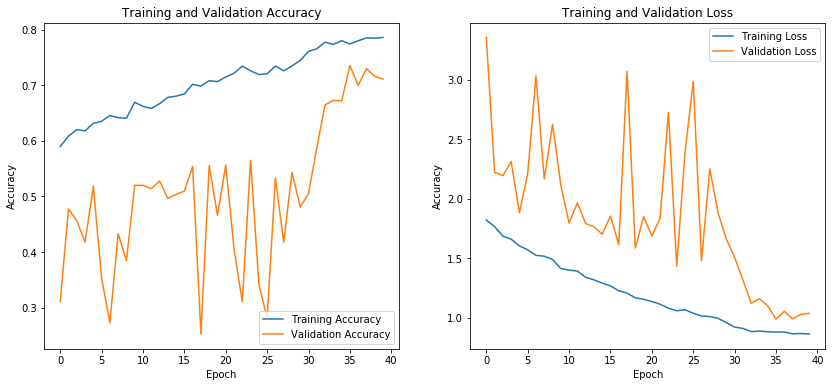

In [22]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(config["NUM_EPOCHS"])

plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

`Tensorboard`

## Predict new samples

In [23]:
# Fetch one batch from validation dataset
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

0.6741 esophagitis
0.0095 normal-pylorus
0.0018 ulcerative-colitis
0.0000 normal-cecum
0.3139 normal-z-line
0.0007 polyps
0.0000 dyed-resection-margins
0.0001 dyed-lifted-polyps

Label: normal-z-line
Predicton: esophagitis


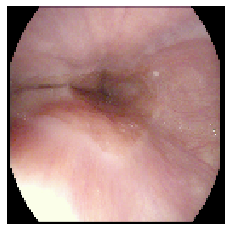

In [24]:
# Get a random image and label
rand = np.random.randint(0, config["BATCH_SIZE"])
image = images[rand]
label = labels[rand]

# Predict one image
predictions = resnet56_model.predict(np.expand_dims(image, axis=0))[0]

for i, pred in enumerate(predictions):
    print("{:0.4f} {}".format(pred,params["class_names"][i]))

print ("\nLabel:", params["class_names"][label])
print ("Predicton:", params["class_names"][np.argmax(predictions)])

plt.figure(frameon=False, facecolor='white')
plt.imshow(image)
plt.axis('off');

In [25]:
# Predict one batch
predictions = resnet56_model.predict(images)

print ('{:3}  {:<25} {:25}'.format('idx', 'label', 'pred'))
print ('---  {} {}'.format(25*'-', 25*'-'), end='')

for i, pred in enumerate(predictions):
    label = params["class_names"][labels[i]]
    prediction = params["class_names"][np.argmax(pred)]
    print ('\n{:3}  {:25} {:25}'.format(i, label, prediction), end='')
    if (label != prediction): print ("  Wrong", end='')

idx  label                     pred                     
---  ------------------------- -------------------------
  0  normal-cecum              normal-cecum             
  1  ulcerative-colitis        ulcerative-colitis       
  2  esophagitis               normal-z-line              Wrong
  3  dyed-resection-margins    esophagitis                Wrong
  4  dyed-lifted-polyps        dyed-lifted-polyps       
  5  esophagitis               esophagitis              
  6  normal-cecum              normal-cecum             
  7  esophagitis               esophagitis              
  8  normal-pylorus            normal-pylorus           
  9  esophagitis               normal-z-line              Wrong
 10  polyps                    ulcerative-colitis         Wrong
 11  normal-z-line             normal-z-line            
 12  dyed-lifted-polyps        polyps                     Wrong
 13  esophagitis               normal-z-line              Wrong
 14  ulcerative-colitis        ulcerative-coli